# Deep Learning Tutorial

Original code taken from
"Deep learning – Convolutional neural networks and feature extraction with Python"
by Christian S. Perone
http://blog.christianperone.com/2015/08/convolutional-neural-networks-and-feature-extraction-with-python/

Learning Material:
http://cs231n.github.io/

Change notes:
- Updated for Python3
- Changed iteration model to Adam, lowered step size
- Changed convolution padding to preserve output dimensions
- Changed architecture to instead use multiple 3×3 filters

## 0. Initialization

### 0.0. Library imports

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from urllib.request import urlretrieve
import _pickle as pickle
import os
import gzip
import numpy as np
import theano
import lasagne
from lasagne import layers
from lasagne.updates import nesterov_momentum
from lasagne.updates import adam
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import visualize
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
%matplotlib inline

Using cuDNN version 6021 on context None
Mapped name None to device cuda0: GeForce GTX 1060 6GB (0000:01:00.0)


### 0.1. MINST Dataset loading function

In [2]:
def load_dataset():
    url = 'http://deeplearning.net/data/mnist/mnist.pkl.gz'
    filename = 'mnist.pkl.gz'
    if not os.path.exists(filename):
        print("Downloading MNIST dataset...")
        urlretrieve(url, filename)
    with gzip.open(filename, 'rb') as f:
        data = pickle.load(f, encoding='latin1')
    X_train, y_train = data[0]
    X_val, y_val = data[1]
    X_test, y_test = data[2]
    X_train = X_train.reshape((-1, 1, 28, 28))
    X_val = X_val.reshape((-1, 1, 28, 28))
    X_test = X_test.reshape((-1, 1, 28, 28))
    y_train = y_train.astype(np.uint8)
    y_val = y_val.astype(np.uint8)
    y_test = y_test.astype(np.uint8)
    return X_train, y_train, X_val, y_val, X_test, y_test

### 0.2. Load dataset
And preview an item.

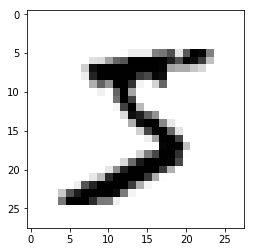

In [3]:
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
plt.imshow(X_train[0][0], cmap=cm.binary)
plt.show()

## 1. ConvNet Architecture and Training

### 1.1. Define the CNN

In [4]:
net1 = NeuralNet(
    layers=[('input', layers.InputLayer),
            ('conv2d1a', layers.Conv2DLayer), # Added to swap 5x5 filters with two 3x3 filters
            ('conv2d1', layers.Conv2DLayer),
            ('maxpool1', layers.MaxPool2DLayer),
            ('conv2d2a', layers.Conv2DLayer),
            ('conv2d2', layers.Conv2DLayer),
            ('maxpool2', layers.MaxPool2DLayer),
            ('dropout1', layers.DropoutLayer),
            ('dense', layers.DenseLayer),
            ('dropout2', layers.DropoutLayer),
            ('output', layers.DenseLayer),
            ],
    # input layer
    input_shape=(None, 1, 28, 28),
    # layer conv2d1a
    conv2d1a_num_filters=8,
    conv2d1a_pad='same', # Pad input with zeroes for same size output
    conv2d1a_filter_size=(3, 3),
    conv2d1a_nonlinearity=lasagne.nonlinearities.rectify,
    conv2d1a_W=lasagne.init.GlorotUniform(),  
    # layer conv2d1
    conv2d1_num_filters=4,
    conv2d1_pad='same', # Pad input with zeroes for same size output
    conv2d1_filter_size=(3, 3),
    conv2d1_nonlinearity=lasagne.nonlinearities.rectify,
    # layer maxpool1
    maxpool1_pool_size=(2, 2),    
    # layer conv2d2a
    conv2d2a_num_filters=8,
    conv2d2a_filter_size=(3, 3),
    conv2d2a_pad='same', # Pad input with zeroes for same size output
    conv2d2a_nonlinearity=lasagne.nonlinearities.rectify,
    # layer conv2d2
    conv2d2_num_filters=4,
    conv2d2_filter_size=(3, 3),
    conv2d2_pad='same', # Pad input with zeroes for same size output
    conv2d2_nonlinearity=lasagne.nonlinearities.rectify,
    # layer maxpool2
    maxpool2_pool_size=(2, 2),
    # dropout1
    dropout1_p=0.5,    
    # dense
    dense_num_units=256,
    dense_nonlinearity=lasagne.nonlinearities.rectify,    
    # dropout2
    dropout2_p=0.5,    
    # output
    output_nonlinearity=lasagne.nonlinearities.softmax,
    output_num_units=10,
    # optimization method params
    # original config in comments
    update=adam, # nesterov_momentum,
    update_learning_rate=0.001, # 0.01,
    # Adam doesn't need update_momentum
    # update_momentum=0.9,
    max_epochs=10,
    verbose=1,
    )

### 1.2. Perform fitting/training

In [5]:
# Train the network
paramFile = 'convNetParams'
trainAnyway = True
if not os.path.exists(paramFile) or trainAnyway:
    nn = net1.fit(X_train, y_train)
    net1.save_params_to(paramFile)
else:
    try:
        net1.load_params_from(paramFile)
    except Exception:
        nn = net1.fit(X_train, y_train)
        net1.save_params_to(paramFile)

# Neural Network with 53962 learnable parameters

## Layer information

  #  name      size
---  --------  -------
  0  input     1x28x28
  1  conv2d1a  8x28x28
  2  conv2d1   4x28x28
  3  maxpool1  4x14x14
  4  conv2d2a  8x14x14
  5  conv2d2   4x14x14
  6  maxpool2  4x7x7
  7  dropout1  4x7x7
  8  dense     256
  9  dropout2  256
 10  output    10

  epoch    trn loss    val loss    trn/val    valid acc  dur
-------  ----------  ----------  ---------  -----------  -----
      1     0.92393     0.24149    3.82586      0.93203  8.96s
      2     0.44941     0.17588    2.55521      0.94963  8.79s
      3     0.34548     0.13605    2.53935      0.96072  8.75s
      4     0.30308     0.11709    2.58842      0.96592  8.80s
      5     0.26336     0.10418    2.52805      0.96942  8.68s
      6     0.24294     0.09475    2.56400      0.97291  8.57s
      7     0.22392     0.08217    2.72510      0.97621  8.61s
      8     0.20555     0.08031    2.55933      0.97711  8.75s
      9     0.19448 

In [6]:
def get_history(nnet):
    history = net1.train_history_
    T = len(history)
    epochs = np.zeros(T)
    durs = np.zeros(T)
    tr_loss = np.zeros(T)
    va_loss = np.zeros(T)
    va_acc = np.zeros(T)
    for k in range(T):
        epochs[k] = history[k]['epoch']
        durs[k] = history[k]['dur']
        tr_loss[k] = history[k]['train_loss']
        va_loss[k] = history[k]['valid_loss']
        va_acc[k] = history[k]['valid_accuracy']
    
    return va_loss, tr_loss, va_acc, durs, epochs

In [7]:
va_loss, tr_loss, va_acc, durs, epochs = get_history(net1)

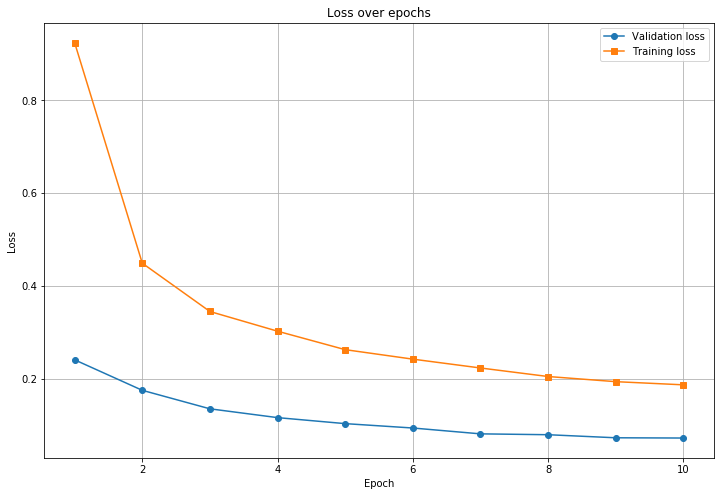

In [8]:
plt.figure(figsize=(12,8))
plt.plot(epochs,va_loss,'o-')
plt.plot(epochs,tr_loss,'s-')
plt.ylabel("Loss")
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.legend(["Validation loss","Training loss"])
plt.grid()
plt.show()

### 1.3. Prediction and Confusion Matrix

In [9]:
# Predict test dataset
preds = net1.predict(X_test)

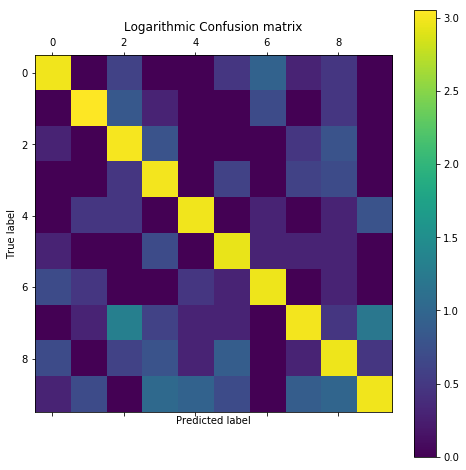

In [10]:
confmat = np.log10(confusion_matrix(y_test, preds)+1)
plt.figure(figsize=(8,8))
plt.matshow(confmat, fignum=1)
plt.title('Logarithmic Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [11]:
# Classification report was imported, but not used
print("Classification report")
print(classification_report(y_test, preds, target_names=[str(x) for x in range(10)]))

Classification report
             precision    recall  f1-score   support

          0       0.99      0.98      0.99       980
          1       0.99      0.99      0.99      1135
          2       0.97      0.99      0.98      1032
          3       0.97      0.99      0.98      1010
          4       0.99      0.99      0.99       982
          5       0.98      0.99      0.99       892
          6       0.99      0.99      0.99       958
          7       0.98      0.96      0.97      1028
          8       0.97      0.98      0.97       974
          9       0.98      0.96      0.97      1009

avg / total       0.98      0.98      0.98     10000



## 2. Inside the network

Plot of filter weights

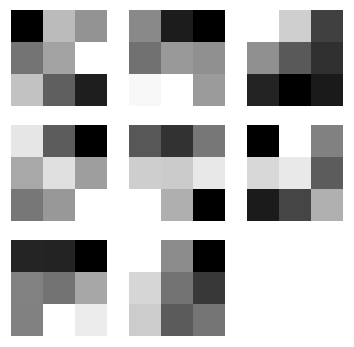

In [12]:
visualize.plot_conv_weights(net1.layers_['conv2d1a'])
plt.show()

### 2.0. Define input object

In [13]:
# Need this as input object for defined functions
input_var = net1.layers_['input'].input_var
type(input_var)

theano.tensor.var.TensorVariable

### 2.1. Define functions for layers

In [14]:
# Experimentation with 1st layer outputs
conv2d1a_layer = layers.get_output(net1.layers_['conv2d1a'], deterministic=True)
conv2d1_layer = layers.get_output(net1.layers_['conv2d1'], deterministic=True)
conv2d2a_layer = layers.get_output(net1.layers_['conv2d2a'], deterministic=True)
conv2d2_layer = layers.get_output(net1.layers_['conv2d2'], deterministic=True)
f_conv2d1a = theano.function([input_var], conv2d1a_layer)
f_conv2d1 = theano.function([input_var], conv2d1_layer)
f_conv2d2a = theano.function([input_var], conv2d2a_layer)
f_conv2d2 = theano.function([input_var], conv2d2_layer)

In [15]:
# Original examples
dense_layer = layers.get_output(net1.layers_['dense'], deterministic=True)
output_layer = layers.get_output(net1.layers_['output'], deterministic=True)
f_output = theano.function([input_var], output_layer)
f_dense = theano.function([input_var], dense_layer)

### 2.2. Test case

In [16]:
# Select test input
idx=0 # index of test case in data
instance = X_test[idx][None, :, :]
actual_value = y_test[idx]

In [17]:
def load_external_image(file):
    from scipy import misc
    img = misc.imread(file,flatten=True)
    img = misc.imresize(img,(28,28))
    img = img.astype(np.float32)
    img *= -1
    img -= np.min(img)
    img /= np.max(img)
    img = img.reshape(1,1,28,28)
    return img

In [18]:
test = load_external_image("test.png")
instance = test
actual_value = 2

In [19]:
# Examine speed of entire trained network
%timeit -n 500 f_output(instance)

500 loops, best of 3: 619 µs per loop


In [20]:
# Examine speed of entire trained network with nolearn's implementation
%timeit -n 500 net1.predict_proba(instance)

500 loops, best of 3: 636 µs per loop


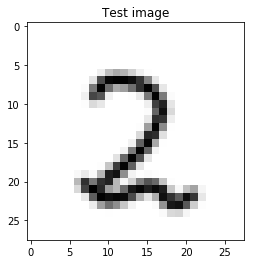

In [21]:
# Examine test input
plt.figure(figsize=None)
plt.title("Test image")
plt.imshow(instance[0][0], cmap=cm.binary)
plt.show()

### 2.3. Plot 1st conv layer outputs

In [22]:
def plot_layer_outputs(layer_outputs):
    plt.figure(figsize=(16,18))
    for k in range(layer_outputs.shape[1]):
        plt.subplot(6,6,k+1)
        plt.title( "Filter #" + str(k+1) )
        plt.imshow(layer_outputs[0,k], cmap=cm.binary)
    plt.show()

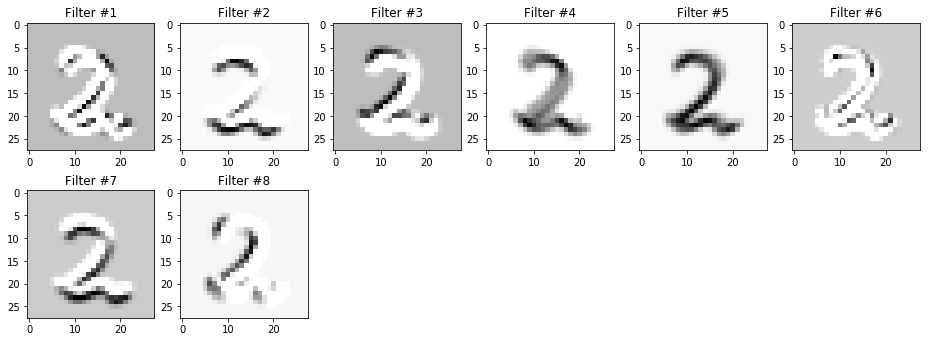

In [23]:
predConv2d1a = f_conv2d1a(instance)
plot_layer_outputs(predConv2d1a)

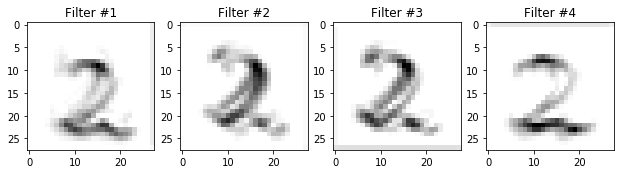

In [24]:
predConv2d1 = f_conv2d1(instance)
plot_layer_outputs(predConv2d1)

### 2.4. Plot 2nd conv layer outputs

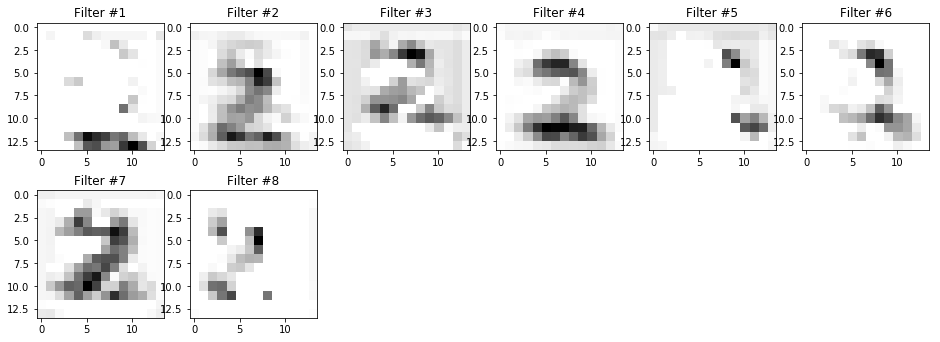

In [25]:
predConv2d2a = f_conv2d2a(instance)
plot_layer_outputs(predConv2d2a)

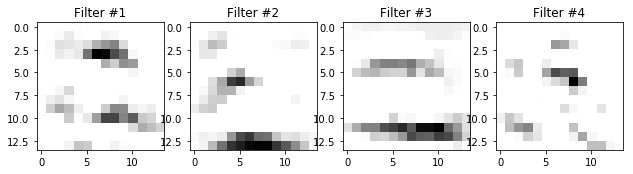

In [26]:
predConv2d2 = f_conv2d2(instance)
plot_layer_outputs(predConv2d2)

### 2.5. Plot dense layer output

In [27]:
def plot_layer_activation(layer_activation):
    N = layer_activation.shape[1]
    plt.figure(figsize=None)
    plt.bar(range(N), layer_activation.ravel())
    plt.show()

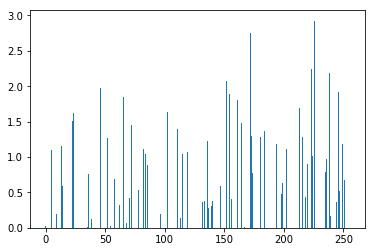

In [28]:
predDense = f_dense(instance)
plot_layer_activation(predDense)

### 2.6. Plot output layer output

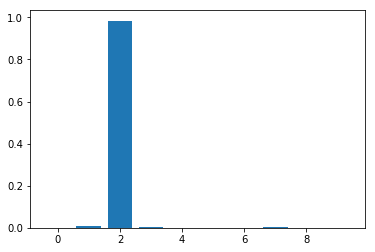

In [29]:
pred = f_output(instance)
plot_layer_activation(pred)

### 2.7. Perform prediction

In [30]:
print("Prediction: %d" % np.argmax(pred[0]))
print("Actual value: %d" % actual_value)

Prediction: 2
Actual value: 2
